<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Dynamic systems: 4. Heat 
## Heat diffusion with  `laplacianFoam`
---
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

**In this notebook, we will learn to**

- use `laplacianFoam` to prepare a simple model for solving the diffusion equation for heat. 

**Prerequisites:** (text)

**Result:** You should get a figure similar to
<img src="images/HeatDiffusion1.jpg" style=width:10cm>

<a href="#top">**Table of contents**</a>

1. [Solver and equations](#one)
2. [Implementation](#two)
3. [Running](#three)
4. [Post-processing](#four)
5. [Technical aspects](#five)

<div id="one"></div>

----
## 1. Solver and equations

`laplacianFoam` is a 

- steady-state or transient

solver for the time-dependent diffusion equation with source term.

We thus need the continuity equation and the Fourier law:
$$
\begin{array}{rcl}
\rho c_p \frac{\partial T}{\partial t}  
+ \nabla \cdot \vec{F} &=& H^* \\
\vec{F} &=& - K_h \nabla T
\end{array}
$$
with
$\rho$ [kg/m$^3$] density,
$c_p$ [J/kg/K] specific heat,
$T$ [K] temperature,
$t$ [s] time,
$\nabla$ [1/m] nabla operator,
$K_h$ [W/m/K] thermal conductivity, 
$F$ [J/m$^2$/s] heat flux, and
$H^*$ [W/m$^3$] heat sources.

Inserting yields:
$$
\frac{\partial T}{\partial t}   
- \nabla \cdot \kappa_h \nabla T = {{H^*}\over{\rho c_p}}
$$
with $\kappa_H$ [m$^2$/s] thermal diffusivity, defined as
$$
\kappa_H = \frac{K_H}{\rho c_p}
$$.

This equation is solved by `laplacianFoam`...

We reduce the problem to steady state and 1D:
$$  
-\kappa_H \frac{d^2T}{dx^2} = {{H^*}\over{\rho c_p}}
$$
Fixing temperature along the left ($T(x=0)=T_0$) and the right side ($T(x=L)=T_1$),
an analytical solution is
$$
T(x) = -\frac{H^*}{2 \rho c_p \kappa_H} x^2 + c_1 x + c_2
$$
with
$$
\begin{array}{rcl}
c_1 &=& \frac{T_1-T_0}{L} + \frac{H^*}{2 \rho c_p \kappa_H} L \\
c_2 &=& T_0
\end{array}
$$

<div id="two"></div>

----
## 2. Implementation

We consider flow along a channel 10 m long, from left to right:
<img src="images/1D_heat.jpg" style=width:15cm>
Black numbers mark sizes, red numbers are vertex numbers.

For the 1D diffusion of heat in a metal bar. The bar is 10m long, 5m wide, and 10cm high.
Thermal diffusivity is $\kappa_h=10^{-6}$m$^2$/s, the heat source is $\frac{H^*}{\rho c_p}=10^{-5}$K/s.

The left face is set to a fixed temperature ($T(x=0)=400$K), the right face
also ($T(x=L)=500$K). Front and back faces are grouped as sides, and have a `zeroGradient` boundary.
The other faces are not relevant, as we consider a 2D problem, thus they will be defined empty.

### Directory structure and files

~~~
HeatDiffusion_laplacianFoam
|-- 0
  |-- T
|- constant
  |-- transportProperties
  |-- fvModels
|- system
  |-- blockMesh
  |-- controlDict
  |-- fvSchemes
  |-- fvSolution
~~~

----

- `system/blockMeshDict`

    - We use no scaling (`convertToMeters`)
    - Eight vertices are defined (`vertices`), use the figure above. 
    The model domain is 10m long in $x$ direction, 
    5m long in the $y$ direction, and has dimensions of 0.1m in $z$ direction.
    - From the eight vertices, a single block (`blocks`) is created as mesh,
    discretised with 100 points in $x$ direcion, ans 50 points in $x$ direction, and 1 point in $z$ direction,
    which means the problem is pseudo-two dimensional!
    Choose direction of points such that the normal vectors are pointing outside! 
    - All edges are straight, thus the keyword `edges` is empty.
    - The boundries are defined (`boundary`). Only four faces, left and right sides as well as front
    and back sides, are relevant, 
    and defined as `wall`. The other two faces (top,bottom), are empty, here the equations are not solved.

<details><summary><b>> Show code</b></summary>

~~~
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    object      blockMeshDict;
}
    
convertToMeters 1;

vertices
(   
    (      0     0      0)
    (     10     0      0)
    (     10     5      0)
    (      0     5      0)
    (      0     0      0.1)
    (     10     0      0.1)
    (     10     5      0.1)
    (      0     5      0.1)
);

blocks
(   
    hex (0 1 2 3 4 5 6 7) (100 50 1) simpleGrading (1 1 1)
);

edges
(
);
boundary
(   
    left { type wall;
        faces
        (   
            (0 4 7 3)
        );
    }
    right { type wall;
        faces
        (
            (1 2 6 5)
        );
    }
    sides { type wall;
        faces
        (
            (0 1 5 4)
            (2 3 7 6)
        );
    }
    empty { type empty;
        faces
        (
            (0 1 2 3)
            (4 5 6 7)
        );
    }
);

mergePatchPairs
(
);
~~~
</details>



----

- File `0/T`

    - Dimensions are set for temperatures (`dimensions`).
    - Set all temperatures to 450K, except ...
    - At the `left`, set temperature to 400K.
    - At the `right`, set temperature to 500K.
    - Fix side temperatures to zero gradient.

<details><summary><b>> Show code</b></summary>
    
~~~
FoamFile
{
    version     2.0;
    format      ascii;
    class       volScalarField;
    object      T;
}
    
dimensions      [0 0 0 1 0 0 0];

internalField   uniform 450;

boundaryField
{
    left
    { type            fixedValue;
      value           uniform 400;
    }
    right
    { type            fixedValue;
      value           uniform 500;
    }
    sides
    { type            zeroGradient;
    }
    empty
    { type            empty;
    }
}
~~~
</details>



----

- File `constant/transportProperties`

    - The thermal diffusivity (`DT`) is set to $10^{-6}$ m$^2$/s.

<details><summary><b>> Show code</b></summary>
    
~~~
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "constant";
    object      transportProperties;
}
    
DT              DT [0 2 -1 0 0 0 0] 1e-6; // thermal diffusivity [m^2/s]
~~~
</details>



----

- File `constant/fvModels`

    - We use `fvModels`to implement a source term.
    - We define a **heat source** with `semiImplicitSource`
    - We define a time range with `timeStart`and `duration`, for which the source term is active.
    - With `selectionMode points` all points in the interior box defined by the coordinates
    are used. `all` would use all points ...
    - `volumeMode`is set to **specific**, thus normalized by the volume (but why?).
    - The keyword `injectionRateSuSp` define the source, in this case a temperature gradient of
    $\frac{H^*}{\rho c_p}=10^{-5}$K/s.
    - Note that we have an explicit and an implicit part, here the implicit part is set to zero:
    $S(x)=S_u + S_p x$, with $S$ the source term, $S_u$ the explicit part, and $S_p$ the implicit part,
    for the latter, the value is given as coefficient.

<details><summary><b>> Show code</b></summary>
    
~~~
FoamFile
{ 
    version     2.0;
    format      ascii; 
    class       dictionary;
    location    "constant"; 
    object      fvModels; 
} 
    
heatSource
{
    type            semiImplicitSource;

    timeStart       0.0;
    duration        1000;
    selectionMode   all; // all, cellSet, cellZone, points
    /*
    selectionMode   points;
        points
        (
            (-0.01 0.01 0)
            (0.03 -0.015 0)
        );
    */

    //volumeMode      absolute; // [unit]
    volumeMode      specific; // [unit]/m3

    sources
    {
        T
        {
            explicit    1e-5;
            implicit    0;
        }
    }
}
~~~
</details>

----

- `system/controlDict`

    - Our example starts from (`startFrom`), set to time 0 (`startTime`).
    - We run the example til the next write (`stopAt`), set with (`nextWrite`).
    - Time step is set to 1 seconds (`deltaT`), which is also the end time (`endTime`).
    - We write the solution each time step (`writeInterval`), thus only one time in this simulation.
    - We keep all solution directories (`purgeWrite 0`).
    - We save the solution in ascii format (`writeFormat ascii`).
    - Write precision is set to 6 digits (`writePrecision 6`). 
    - The option `runTimeModifiable` is on, we therefore can modify all
    these entries while we are running the simulation.

<details><summary><b>> Show code</b></summary>

~~~
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      controlDict;
}
    
application     laplacianFoam;
startFrom        startTime;
startTime       0;
stopAt           nextWrite;
endTime         1;
deltaT          1;
writeControl     timeStep;
writeInterval    1;
purgeWrite      0;
writeFormat     ascii;
writePrecision  6;
writeCompression off;
timeFormat      general;
timePrecision   6;
runTimeModifiable true;
~~~
</details>



----

- File `system/fvSchemes`

    - The model is steady state (`ddtSchemes`).
    - Gradients are solved with the Gauss linear methods (`gradSchemes`).
    - Divergence is solved with the default solver (`divSchemes`).
    - Laplacians are solved with a Gauss linear method (`laplacianSchemes`).

<details><summary><b>> Show code</b></summary>
    
~~~
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      fvSchemes;
}
    
ddtSchemes
{
    //default         Euler;
    default         steadyState;
}

gradSchemes
{
    default         none;
    grad(T)         Gauss linear;
}

divSchemes
{
    default         none;
}

laplacianSchemes
{
    default         none;
    laplacian(DT,T) Gauss linear corrected;
}

interpolationSchemes
{
    default         linear;
}

snGradSchemes
{
    default         corrected;
}

fluxRequired
{
    default         no;
}
~~~
</details>



----

- File `system/fvSolution`

    - Temperature $T$ is solved with the **PCG** method to a given absolute tolerance,
    and a given relative tolerance.
    - The **SIMPLE** block defines the coupling with the **simple** method, which is
    actually not used, because there is only one variable.

<details><summary><b>> Show code</b></summary>
    
~~~
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    location    "system";
    object      fvSolution;
}
    
solvers
{
    T
    {
        solver          PCG;
        preconditioner  DIC;
        tolerance       1e-06;
        relTol          0;
    }
}

SIMPLE
{
    nNonOrthogonalCorrectors 0;
}
~~~
</details>

<div id="three"></div>

----
## 3. Running

Running a particular example is done with the following set of commands:
~~~
$ foamCleanTutorials
$ blockMesh
$ laplacianFoam
~~~

If the run was successful, create a dummy file `show.foam` in the directory and
open the run in `paraview`.

<img src="images/HeatDiffusion1.jpg" style=width:10cm>
<img src="images/HeatDiffusion2.jpg" style=width:10cm>

<div id="four"></div>

----
## 4. Post-processing: Profiles

Use dictionary `system/sampleDict` to extract data after main run.
- We define `sets`
- We set the output format to ascii (`setFormat raw`).
- We set the interpolation as cell-point centeres (*interpolationScheme`).
- The fields are defined (`fields`). Note that is matters, wether the different fields
are in one line or in separate line, as this controls the naming of the output files ...
- Then the sets are given, with a name (e.g. `metalbar`), the sample type
(`type uniform`) and the sample number (`nPoints 100`), the axes to sample (`xyz`means
all three axes), and the start and end points of the uniform sampling (`start`, `end`).

<details><summary><b>> Show code</b></summary>
    
~~~
FoamFile
{
    version     2.0;
    format      ascii;
    class       dictionary;
    object      sampleDict;
}
    
type sets;

setFormat raw;

interpolationScheme cell;
//interpolationScheme cellPoint;
//interpolationScheme cellPointFace;

// Fields to sample.
fields
(
    T
);

sets
(
    metalbar
    {
        type          lineUniform;
        nPoints       100;

        axis            xyz;
        start           ( 0  2.5 0.05);
        end             (10  2.5 0.05);
    }

);
~~~
</details>

Run:

~~~
$ postProcess -func sampleDict -latestTime
~~~

The `postProcess` code creates in this case sampled data for temperature $T$ in a directory
`postProcessing/sampleDict/1/metalbar_T.xy`.

We compare the calculated data with the analytical solution with `python`:

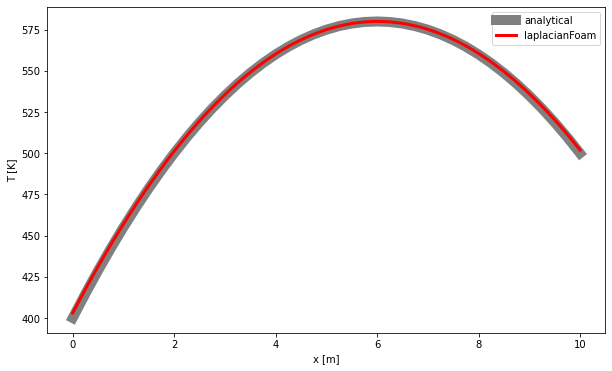

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# calculate analytical data
def T(x,T0=400,T1=500):
    Hsternrhocp = 1e-5
    D           = 1e-6
    L           = 10
    c1 = (T1-T0)/L + Hsternrhocp/2/D*L
    c2 = T0
    T = -Hsternrhocp/2/D*x**2 + c1*x + c2
    return T
    
x = np.linspace(0,10,41)
Tanalytical = T(x)

# load laplacianFoam postprocessed data
data = np.loadtxt('data/metalbar_T.xy')
#print(data)

plt.figure(figsize=(10,6))
plt.xlabel('x [m]')
plt.ylabel('T [K]')
plt.plot(x,Tanalytical,linewidth=10,color='gray',label='analytical')
plt.plot(data[:,0],data[:,3],linewidth=3,color='red',label='laplacianFoam')
plt.legend()

... done